## **Step 1 : importing Essential Libraries**



In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator # for augmentation
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input # for augmentation
import keras.applications
help(keras.applications)
print(keras.__version__)
from keras import backend as K 

Help on package keras.applications in keras:

NAME
    keras.applications

PACKAGE CONTENTS
    densenet
    imagenet_utils
    inception_resnet_v2
    inception_v3
    mobilenet
    mobilenet_v2
    nasnet
    resnet
    resnet50
    resnet_v2
    vgg16
    vgg19
    xception

FILE
    /usr/local/lib/python3.6/dist-packages/keras/applications/__init__.py


2.4.3


**Function defined to find optimal batch size :**

In [ ]:
def FindBatchSize(model):
    """#model: model architecture, that is yet to be trained"""
    import os, sys, psutil, gc, tensorflow, keras
    import numpy as np
    from keras import backend as K
    BatchFound= 16

    try:
        total_params= int(model.count_params());    GCPU= "CPU"
        #find whether gpu is available
        try:
            if K.tensorflow_backend._get_available_gpus()== []:
                GCPU= "CPU";    #CPU and Cuda9GPU
            else:
                GCPU= "GPU"
        except:
            from tensorflow.python.client import device_lib;    #Cuda8GPU
            def get_available_gpus():
                local_device_protos= device_lib.list_local_devices()
                return [x.name for x in local_device_protos if x.device_type == 'GPU']
            if "gpu" not in str(get_available_gpus()).lower():
                GCPU= "CPU"
            else:
                GCPU= "GPU"

        #decide batch size on the basis of GPU availability and model complexity
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <1000000):
            BatchFound= 64    
        if (os.cpu_count() <16) and (total_params <500000):
            BatchFound= 64  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <2000000) and (total_params >=1000000):
            BatchFound= 32      
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=2000000) and (total_params <10000000):
            BatchFound= 16  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=10000000):
            BatchFound= 8       
        if (os.cpu_count() <16) and (total_params >5000000):
            BatchFound= 8    
        if total_params >100000000:
            BatchFound= 1

    except:
        pass
    try:

        #find percentage of memory used
        memoryused= psutil.virtual_memory()
        memoryused= float(str(memoryused).replace(" ", "").split("percent=")[1].split(",")[0])
        if memoryused >75.0:
            BatchFound= 8
        if memoryused >85.0:
            BatchFound= 4
        if memoryused >90.0:
            BatchFound= 2
        if total_params >100000000:
            BatchFound= 1
        print("Batch Size:  "+ str(BatchFound));    gc.collect()
    except:
        pass

    memoryused= [];    total_params= [];    GCPU= "";
    del memoryused, total_params, GCPU;    gc.collect()
    return BatchFound
##########################################################################################################################################

In [ ]:
# getting images directly from ISIC:
'''
! pip install requests
! pip install Pillow
! pip install tqdm

from google.colab import drive
from google.colab import files
files.upload() 
'''


'\n! pip install requests\n! pip install Pillow\n! pip install tqdm\n\nfrom google.colab import drive\nfrom google.colab import files\nfiles.upload() \n'

In [ ]:
# getting images from ISIC directly:
#path = '/content/drive/My Drive/Melanoma_project/ISIC_malignant'
#! python download_archive.py --filter malignant --images-dir '/content/drive/My Drive/Melanoma_project/ISIC_malignant' 

In [ ]:
# getting images from ISIC directly:
#path = '/content/drive/My Drive/Melanoma_project'
#! python download_archive.py --filter benign --images-dir '/content/drive/My Drive/Melanoma_project/ISIC_benign'

In [ ]:
'''
!apt-get install rar
!zip -r "/content/drive/My Drive/Melanoma_project/ISIC_images.zip" "/content/drive/My Drive/Melanoma_project/ISIC_images"
'''

'\n!apt-get install rar\n!zip -r "/content/drive/My Drive/Melanoma_project/ISIC_images.zip" "/content/drive/My Drive/Melanoma_project/ISIC_images"\n'

In [ ]:


from google.colab import drive
from pathlib import Path

# ref : https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf

zip_path = '/content/drive/My Drive/Melanoma_project/ISIC_images.zip'
!cp "{zip_path}" .
!unzip -q ISIC_images.zip
!rm ISIC_images.zip  # to copy the zip from drive to colab and then get the data - makes the loading process much faster

^C
[ISIC_images.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of ISIC_images.zip or
        ISIC_images.zip.zip, and cannot find ISIC_images.zip.ZIP, period.


In [ ]:
# Load in pictures 
import numpy as np
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

import os
ims_benign = [read(os.path.join('/content/content/drive/My Drive/Melanoma_project/ISIC_images/ISIC_benign', filename)) for filename in os.listdir('/content/content/drive/My Drive/Melanoma_project/ISIC_images/ISIC_benign')]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join('/content/content/drive/My Drive/Melanoma_project/ISIC_images/ISIC_malignant', filename)) for filename in os.listdir('/content/content/drive/My Drive/Melanoma_project/ISIC_images/ISIC_malignant')]
X_malignant = np.array(ims_malignant, dtype='uint8')

FileNotFoundError: ignored

In [ ]:
#-------------------------------------------------------------------------------------------------

-----------------------------------------------------

# **Step 2 : Loading pictures and making Dictionary of images and labels**

In [ ]:
'''folder_benign_train = '/content/drive/My Drive/Melanoma_project/train/benign'
folder_malignant_train = '/content/drive/My Drive/Melanoma_project/train/malignant'

folder_benign_test = '/content/drive/My Drive/Melanoma_project/test/benign'
folder_malignant_test = '/content/drive/My Drive/Melanoma_project/test/malignant'
'''

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

print(read)

In [ ]:
from google.colab import drive
from pathlib import Path

# ref : https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf

zip_path = '/content/drive/My Drive/Melanoma_project/image_folder.zip'
!cp "{zip_path}" .
!unzip -q image_folder.zip
!rm image_folder.zip  # to copy the zip from drive to colab and then get the data - makes the loading process much faster

In [ ]:
# Load in training pictures 
import os
ims_benign = [read(os.path.join('/content/train/benign', filename)) for filename in os.listdir('/content/train/benign')]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join('/content/train/malignant', filename)) for filename in os.listdir('/content/train/malignant')]
X_malignant = np.array(ims_malignant, dtype='uint8')


In [ ]:
# Load in testing pictures

ims_benign = [read(os.path.join('/content/test/benign', filename)) for filename in os.listdir('/content/test/benign')]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join('/content/test/malignant', filename)) for filename in os.listdir('/content/test/malignant')]
X_malignant_test = np.array(ims_malignant, dtype='uint8')


In [ ]:
# Create labels

y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


In [ ]:
# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

In [ ]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

150528
150528
150528
150528
150528
150528
150528
150528
150528
150528
150528
150528
150528
150528
150528


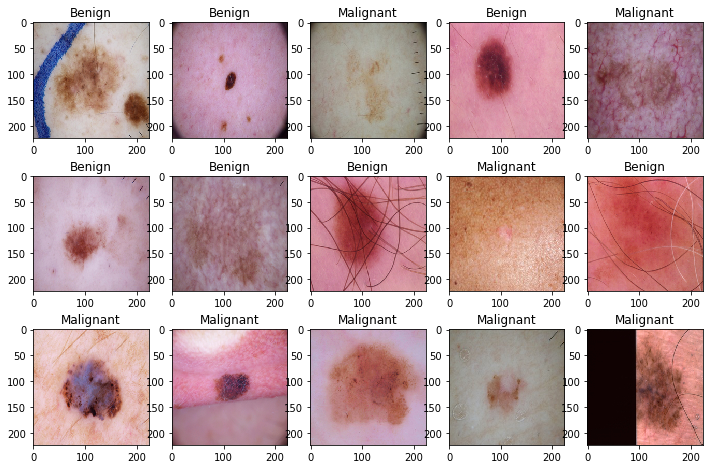

In [ ]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
    print(X_train[i].size)
plt.show()

## **Step 3: Categorical Labels**

In [ ]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

## **Step 4 : Normalization**

In [ ]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

In [ ]:
'''
#---------------------------------------------------------------------------------------------# 
#Data augmentation :

image_size= 224

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2)

train_generator = data_generator_with_aug.flow_from_directory(
        '/content/train',
        target_size=(image_size, image_size),
        batch_size=24,
        class_mode='categorical')

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = data_generator_no_aug.flow_from_directory(
        '/content/test',
        target_size=(image_size, image_size),
        class_mode='categorical')

#------------------------------------XCEPTION MODEL-----------------------------------------------
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = Xception(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

model.fit_generator(
        train_generator,
        steps_per_epoch=3,
        epochs=150,
        validation_data=validation_generator,
        validation_steps=1,
        verbose = 2)
'''

'\n#---------------------------------------------------------------------------------------------# \n#Data augmentation :\n\nimage_size= 224\n\ndata_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,\n                                   horizontal_flip=True,\n                                   width_shift_range = 0.2,\n                                   height_shift_range = 0.2)\n\ntrain_generator = data_generator_with_aug.flow_from_directory(\n        \'/content/train\',\n        target_size=(image_size, image_size),\n        batch_size=24,\n        class_mode=\'categorical\')\n\ndata_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)\n\nvalidation_generator = data_generator_no_aug.flow_from_directory(\n        \'/content/test\',\n        target_size=(image_size, image_size),\n        class_mode=\'categorical\')\n\n#------------------------------------XCEPTION MODEL-----------------------------------------------\ninput_shape = (

In [ ]:
'''
# Data augmentation continuation :
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
'''

'\n# Data augmentation continuation :\n# Testing model on test data to evaluate\ny_pred = model.predict(X_test)\nprint(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))\n'

Trying NasNetLarge:

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',    
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [ ]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50  
batch_size = 64

model = keras.applications.NASNetLarge(
    input_shape=input_shape, include_top=True, weights=None, input_tensor=None,
    pooling='avg', classes=2
)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

 # calling function that gives us the optimal batch size

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/50


ResourceExhaustedError: ignored

In [ ]:
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=[learning_rate_reduction]
         )

In [ ]:
model.save('/content/drive/My Drive/Melanoma_project/nasnet.h5')
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# **Trying out Xception**

In [ ]:
#Declaring stuff :
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',    
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)



In [ ]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 30  # 86.9% accuracy obtained with epochs = 50
batch_size = 64

model = Xception(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

FindBatchSize(model) # calling function that gives us the optimal batch size

Batch Size:  8


8

Epoch 1/30
264/264 - 47s - loss: 0.4898 - accuracy: 0.7539 - val_loss: 0.6905 - val_accuracy: 0.5360
Epoch 2/30
264/264 - 46s - loss: 0.4349 - accuracy: 0.7843 - val_loss: 0.7080 - val_accuracy: 0.5360
Epoch 3/30
264/264 - 46s - loss: 0.4046 - accuracy: 0.8075 - val_loss: 0.4425 - val_accuracy: 0.7614
Epoch 4/30
264/264 - 46s - loss: 0.3954 - accuracy: 0.8084 - val_loss: 0.3436 - val_accuracy: 0.8390
Epoch 5/30
264/264 - 46s - loss: 0.3619 - accuracy: 0.8255 - val_loss: 0.3366 - val_accuracy: 0.8390
Epoch 6/30
264/264 - 46s - loss: 0.3458 - accuracy: 0.8478 - val_loss: 0.3184 - val_accuracy: 0.8485
Epoch 7/30
264/264 - 46s - loss: 0.3110 - accuracy: 0.8668 - val_loss: 0.3331 - val_accuracy: 0.8447
Epoch 8/30
264/264 - 46s - loss: 0.2916 - accuracy: 0.8824 - val_loss: 0.2979 - val_accuracy: 0.8750
Epoch 9/30
264/264 - 46s - loss: 0.2691 - accuracy: 0.8924 - val_loss: 0.2951 - val_accuracy: 0.8598
Epoch 10/30
264/264 - 46s - loss: 0.2124 - accuracy: 0.9170 - val_loss: 0.3532 - val_accura

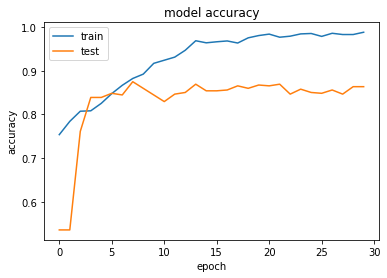

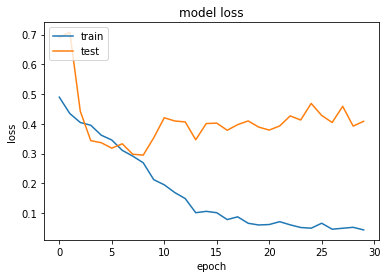

In [ ]:
batch_size=8 # put number depending on result of previous cell

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# my comments :  

In [ ]:
# Train Xception on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=[learning_rate_reduction]
         )

In [ ]:
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# save model
# serialize model to JSON
Xception_json = model.to_json()

with open("Xception.json", "w") as json_file:
    json_file.write(Xception_json)
    
# serialize weights to HDF5
model.save_weights("Xception.h5")
print("Saved model to disk")

# my comments : 

0.8696969696969697
Saved model to disk


# **--------------------------------------------------------------------**

# **Step 5: Model Building**

**CNN**

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 64 filters for the two firsts conv2D layers. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in one fully-connected (Dense) layer which is just artificial an neural networks (ANN) classifier.

In [ ]:
# See learning curve and validation curve

def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',    
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [ ]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50  # originally : 50
batch_size = 64

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0, 
                    callbacks=[learning_rate_reduction]
                   )
                   
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
K.clear_session()
del model
del history

# **Step 6: Cross-Validating Model**

In [ ]:
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []

for train, test in kfold.split(X_train, y_train):
  # create model
    
    model = build(lr=lr, 
                  init= init, 
                  activ= activ, 
                  optim=optim, 
                  input_shape= input_shape)
    
    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model
    break
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


# **Step 7: Testing the model**

In [ ]:
# Fitting model to all data
model = build(lr=lr, 
              init= init, 
              activ= activ, 
              optim=optim, 
              input_shape= input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=0,
          callbacks=[learning_rate_reduction]
         )

# Testing model on test data to evaluate
y_pred = model.predict_classes(X_test)

print(accuracy_score(np.argmax(y_test, axis=1),y_pred))

In [ ]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# Clear memory, because of memory overload
del model
K.clear_session()

# **Step 8: ResNet101**

The CNN above is not a very sophisticated model, thus the resnet50, is also tried

In [ ]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=[learning_rate_reduction]
         )

In [ ]:
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)
    
# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")

In [ ]:
import json

with open("/var/log/colab-jupyter.log", "r") as fo:
  for line in fo:
    print(json.loads(line)['msg'])